# Классификация изображений Симпсонов
Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

from torchvision import transforms, models
from torchvision.utils import make_grid

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

9.5.0


Для обучения CNN использовал ресурсы kaggle, соответственно не загружал данные с kaggle на colab. Посмотрим на файлы и папки в 'Journey to Springfield' dataset


In [3]:
!ls /kaggle/input/journey-springfield -1

characters_illustration.png
sample_submission.csv
testset
train


In [4]:
!ls /kaggle/input/journey-springfield/train

simpsons_dataset


In [5]:
!ls /kaggle/input/journey-springfield/testset

testset


In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Apr 15 18:19:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.

In [7]:
import os
import copy
import pickle
import random
import numpy as np
from datetime import datetime
from collections import OrderedDict
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# установка начального значения для генератора псевдослучайных чисел при использовании функций PyTorch & numpy
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [8]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu ")

Определим класс SimpsonsDataset


In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform=None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Скопируем все файлы и данные из директории /kaggle/input/journey-springfield/ в домашнюю директорию


In [11]:
!cp -r "../input/journey-springfield" "./"

In [12]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('../input/journey-springfield/testset/testset')

In [13]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

**Посчитаем и выведем на диаграмме количество изображений каждого персонажа, содержащихся в нашем датасете**

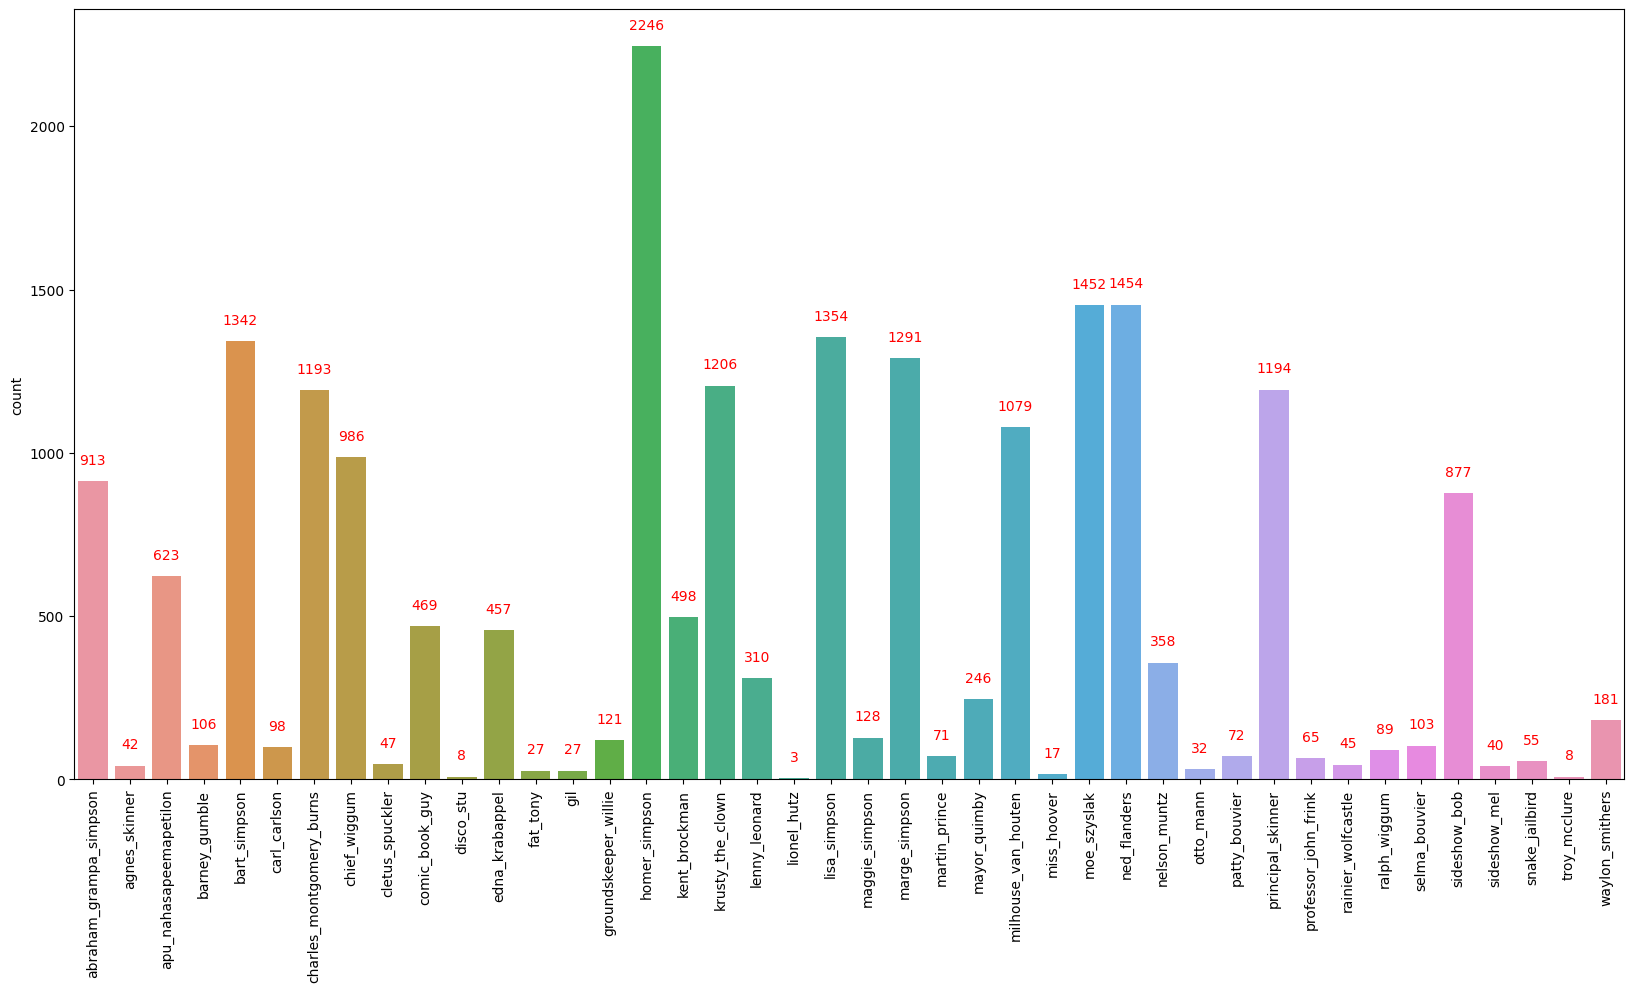

In [15]:
from collections import Counter
import pandas as pd
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 10))

data_dict = dict(Counter([x.parent.name for x in train_val_files]))
data = pd.DataFrame(data = data_dict.values(), index=data_dict.keys(), columns=['count'])
sns.barplot(x = data.index, y = data['count']).set_xticklabels(data.index, rotation=90)
plt.bar_label(ax.containers[0], fmt='%.0f', padding=10, color = 'red', rotation=0, fontsize=10)

plt.show()

Виден очень сильный дисбаланс в распределении персонажей по классам. Попытаемся восполнить его с помощью аугментации. При этом аугментировать будем те изображения, которые меньшего условного "достаточного количества", например, 1000 картинок + аугментировать каждое изображение песонажа будем столько раз, сколько потребуется для восстановления соотв. разницы (между имеющимся количеством картинок и 1000).

In [16]:
df = data.copy()
df['difference'] = (1000 - df['count']).astype(int)
df['multiplier'] = (np.ceil(df['difference'] / df['count'])).astype(int)
df.head()

,count,difference,multiplier
abraham_grampa_simpson,913,87,1
agnes_skinner,42,958,23
apu_nahasapeemapetilon,623,377,1
barney_gumble,106,894,9
bart_simpson,1342,-342,0


Изображения ранее мы подогнали по единый размер, при этом оригинальный размер картинок, исходя из описания, был разным. Соответственно могли потерять какую-то значимую информацию. Немного увеличим изображения + сделаем рандомные срезы + немного повернем в рандомном диапазоне + сделаем горизонтальный флип. Все это в надежде на то, что модель сможет "вытащить" из аугментированных изображений какую-то новую информацию. 

In [17]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=260), 
                                transforms.CenterCrop(size=260),
                                transforms.RandomCrop(260)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-30, 30)),
    'Flip': transforms.RandomHorizontalFlip(p=1)
}

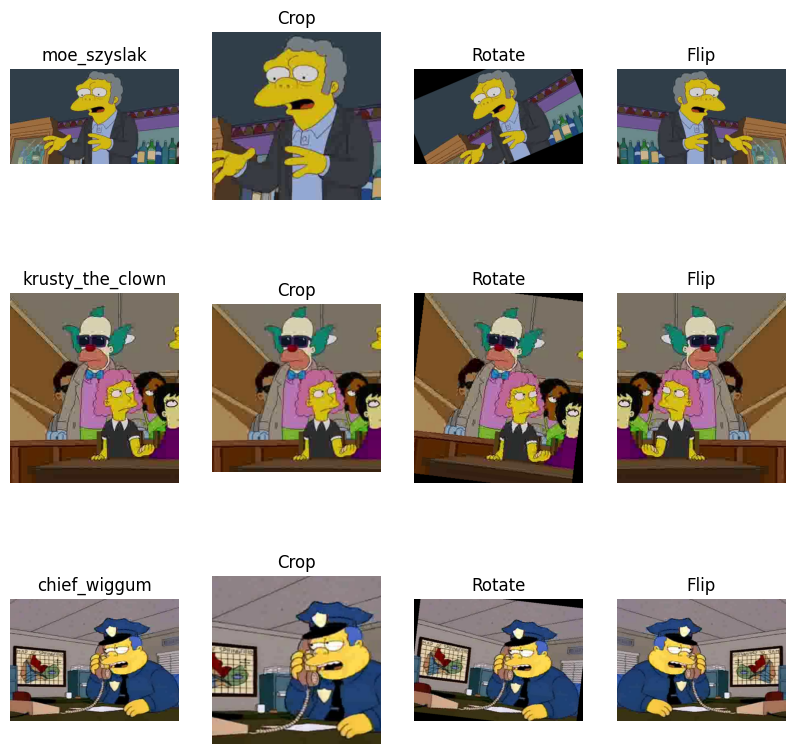

In [18]:
n_examples = 3
train_dataset = SimpsonsDataset(train_val_files, mode='train')

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1),figsize=(10, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    img_orig = train_dataset.load_sample(train_val_files[random_character])
    img_label = train_val_files[random_character].parent.name
    
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')
        
    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

Исходя из описанной выше логики,  применим аугментацию ко всему датасету:

In [19]:
for image_path in tqdm(train_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = train_dataset.load_sample(image_path)
    # if we don't need to add any images, we can continue without transformation
    if df.loc[character]['difference'] <= 0:
        continue
    if df.loc[character]['multiplier'] > df.loc[character]['difference']:
        iter_size = df.loc[character]['difference']
    else:
        iter_size = df.loc[character]['multiplier']
    df.loc[character]['difference'] -= iter_size
    
    for i in range(int(iter_size)):
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

  0%|          | 0/15699 [00:00<?, ?it/s]/tmp/ipykernel_25/1289625471.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[character]['difference'] -= iter_size
100%|██████████| 15699/15699 [01:02<00:00, 253.14it/s]


In [20]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
train_files, _ = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels, random_state=111)

val_dataset = SimpsonsDataset(val_files, mode='val')  
train_dataset = SimpsonsDataset(train_files, mode='train')

In [21]:
len(train_dataset)

32664

Количество данных в в обучающей выборке увеличилось 2Х

В заключение посмотрим на наших героев внутри валидационной части датасета.

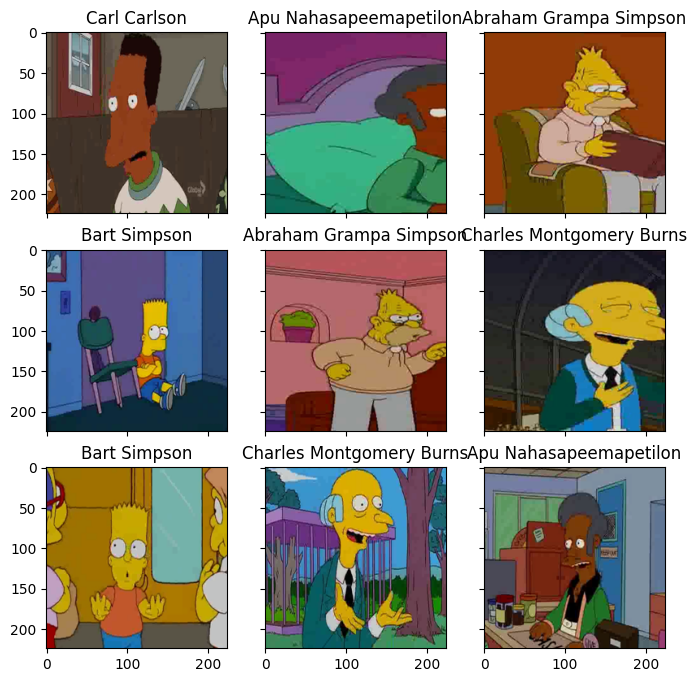

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

**За основу была взята архитектура из учебного ноутбука**:

1. размерность входа: 3x224x224
2. размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5

**Внесенные дополнения**:

1. После каждого сверточного слоя и перед активационной функцией добавлен слой BN.
2. После функции активации в каждом слое добавлен Dropout:
    - после сверточных слоев, дабы снизить переадаптацию к тренировочным данным (верятность совсем небольшая, так сверт. слой сам по себе - регуляризатор);
    - после линейного слоя: здесь значения вероятностей Dropout выше, так как полносвязные слои более склонны к переобучению
3. Добавлены 2-а полносвязных слоя между свёрточными и выходным, с постепенным понижением размерности от 2400---> 1024 ---> 512.

In [23]:
class MyCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.05)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.05)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.05)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.05)
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(96 * 5 * 5, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.out = nn.Linear(512, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = self.linear(x)

#         x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [24]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [25]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

Использован оптимизатор AdamW c коэфициентом (weight_decay) регуляризации, который добавляется напрямую в оптимизатор

In [26]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    opt = torch.optim.AdamW(model.parameters())
    criterion = nn.CrossEntropyLoss()
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [27]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [28]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = MyCnn(n_classes).to(DEVICE)
print(f"we will classify: {n_classes}")
print(simple_cnn)

we will classify: 42
MyCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.05, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.05, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stri

Запустим обучение сети.

In [29]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=128)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.4677408675834474


epoch:   5%|▌         | 1/20 [03:28<1:06:03, 208.61s/it]


Epoch 001 train_loss: 1.4677     val_loss 0.9901 train_acc 0.6177 val_acc 0.7285
loss 0.5960043558201719


epoch:  10%|█         | 2/20 [06:55<1:02:21, 207.86s/it]


Epoch 002 train_loss: 0.5960     val_loss 0.5139 train_acc 0.8314 val_acc 0.8519
loss 0.2625975609555596


epoch:  15%|█▌        | 3/20 [10:23<58:51, 207.75s/it]


Epoch 003 train_loss: 0.2626     val_loss 0.3815 train_acc 0.9210 val_acc 0.8869
loss 0.13845272666970626


epoch:  20%|██        | 4/20 [13:51<55:24, 207.79s/it]


Epoch 004 train_loss: 0.1385     val_loss 0.2597 train_acc 0.9575 val_acc 0.9343
loss 0.10024526867282878


epoch:  25%|██▌       | 5/20 [17:18<51:55, 207.69s/it]


Epoch 005 train_loss: 0.1002     val_loss 0.2742 train_acc 0.9680 val_acc 0.9377
loss 0.07908002748271574


epoch:  30%|███       | 6/20 [20:46<48:25, 207.54s/it]


Epoch 006 train_loss: 0.0791     val_loss 0.3256 train_acc 0.9747 val_acc 0.9280
loss 0.07090634610043155


epoch:  35%|███▌      | 7/20 [24:13<44:55, 207.37s/it]


Epoch 007 train_loss: 0.0709     val_loss 0.3333 train_acc 0.9776 val_acc 0.9284
loss 0.05248278210100636


epoch:  40%|████      | 8/20 [27:40<41:30, 207.50s/it]


Epoch 008 train_loss: 0.0525     val_loss 0.3002 train_acc 0.9840 val_acc 0.9431
loss 0.044426493493585996


epoch:  45%|████▌     | 9/20 [31:08<38:04, 207.66s/it]


Epoch 009 train_loss: 0.0444     val_loss 0.3200 train_acc 0.9863 val_acc 0.9413
loss 0.051913988544529714


epoch:  50%|█████     | 10/20 [34:36<34:36, 207.67s/it]


Epoch 010 train_loss: 0.0519     val_loss 0.3029 train_acc 0.9835 val_acc 0.9412
loss 0.049705999263338956


epoch:  55%|█████▌    | 11/20 [38:04<31:10, 207.80s/it]


Epoch 011 train_loss: 0.0497     val_loss 0.2601 train_acc 0.9837 val_acc 0.9526
loss 0.04853791768727411


epoch:  60%|██████    | 12/20 [41:32<27:43, 207.92s/it]


Epoch 012 train_loss: 0.0485     val_loss 0.2729 train_acc 0.9846 val_acc 0.9511
loss 0.03705020817411831


epoch:  65%|██████▌   | 13/20 [45:01<24:16, 208.12s/it]


Epoch 013 train_loss: 0.0371     val_loss 0.2735 train_acc 0.9892 val_acc 0.9490
loss 0.02399399390370256


epoch:  70%|███████   | 14/20 [48:30<20:50, 208.43s/it]


Epoch 014 train_loss: 0.0240     val_loss 0.2911 train_acc 0.9931 val_acc 0.9505
loss 0.031338324107593754


epoch:  75%|███████▌  | 15/20 [51:58<17:21, 208.22s/it]


Epoch 015 train_loss: 0.0313     val_loss 0.2903 train_acc 0.9901 val_acc 0.9455
loss 0.048345589284428864


epoch:  80%|████████  | 16/20 [55:26<13:52, 208.09s/it]


Epoch 016 train_loss: 0.0483     val_loss 0.3150 train_acc 0.9853 val_acc 0.9471
loss 0.03637438273877524


epoch:  85%|████████▌ | 17/20 [58:54<10:24, 208.12s/it]


Epoch 017 train_loss: 0.0364     val_loss 0.2431 train_acc 0.9892 val_acc 0.9591
loss 0.03209209298870558


epoch:  90%|█████████ | 18/20 [1:02:26<06:58, 209.36s/it]


Epoch 018 train_loss: 0.0321     val_loss 0.2877 train_acc 0.9896 val_acc 0.9459
loss 0.026075691489049785


epoch:  95%|█████████▌| 19/20 [1:05:59<03:30, 210.31s/it]


Epoch 019 train_loss: 0.0261     val_loss 0.2544 train_acc 0.9926 val_acc 0.9601
loss 0.03698197727688314


epoch: 100%|██████████| 20/20 [1:09:32<00:00, 208.64s/it]


Epoch 020 train_loss: 0.0370     val_loss 0.2831 train_acc 0.9892 val_acc 0.9534


Построим кривые обучения

In [30]:
loss, acc, val_loss, val_acc = zip(*history)

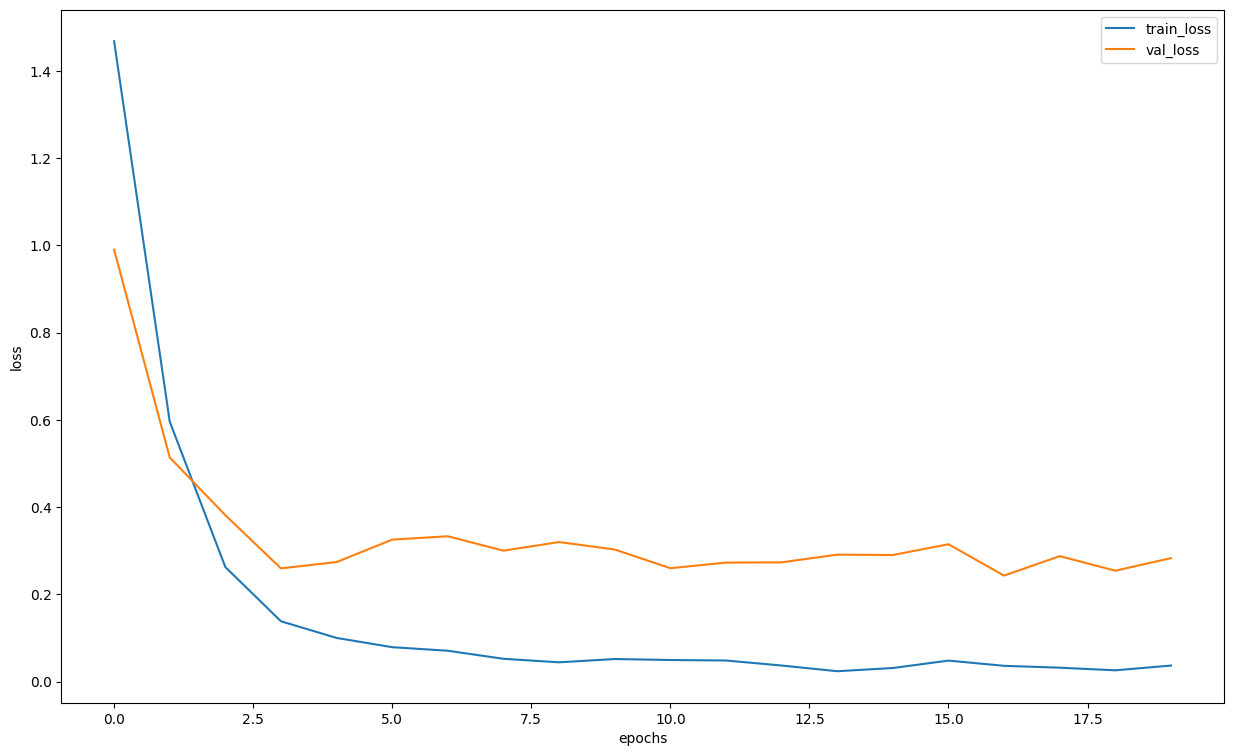

In [31]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Предсказания

In [32]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [33]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [34]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [35]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [36]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [37]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.9


Сделаем классную визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

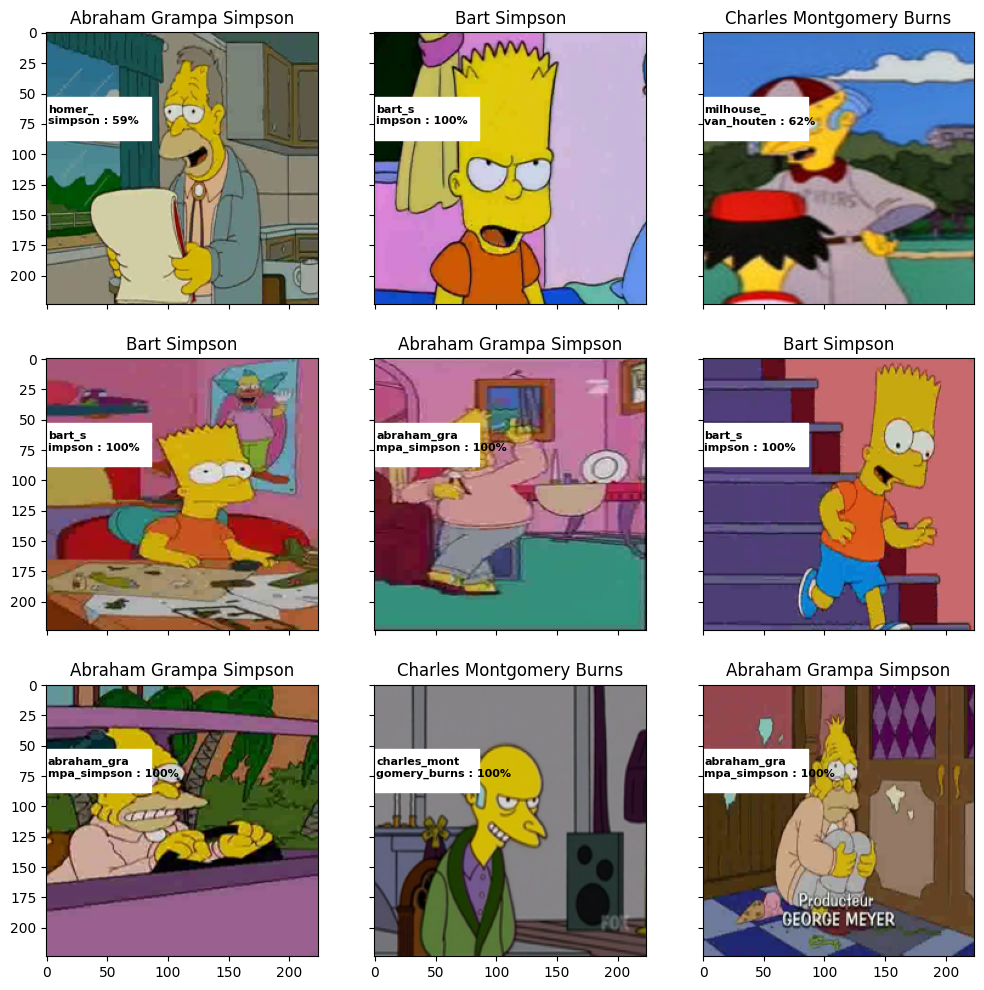

In [38]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [39]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [40]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [41]:
my_submit.to_csv('The_Simpsons_CNN.csv', index=False)

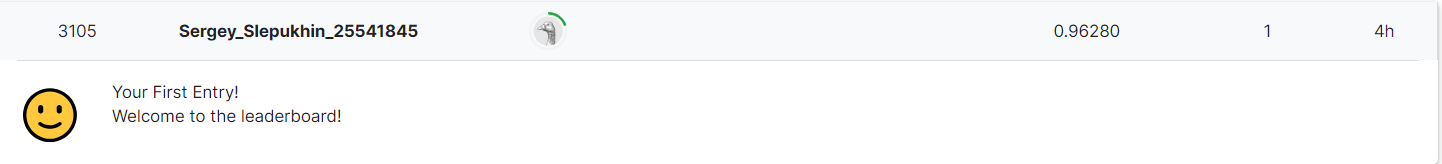